In [2]:
%load_ext autoreload
%autoreload 2

import ml_utils
import numpy as np
import pickle as pkl
from tqdm import tqdm
import sklearn
import matplotlib.pyplot as plt
import gzip
import pickle as pkl
from typing import Callable

In [3]:
with gzip.open("data.pkl.gz", "rb") as f:   data = pkl.load(f)

features: dict[int: dict[str: float]] = data["features"]
time_series: dict[int: dict[str: list[float]]] = data["time_series"]

pIDs: list[int] = list(features.keys())

merged: dict[int: dict[str: float | list[float]]] = {pID: {**features[pID], **time_series[pID]} for pID in pIDs}

In [4]:
X: list[np.ndarray[float]] = []
Y: list[np.ndarray[float]] = []

for t in tqdm(range(len(merged[8405]["IC"]))):

    Xt: list[np.ndarray[float]] = []
    Yt: list[np.ndarray[float]] = []

    for pID in pIDs:

        xt, yt = ml_utils.vectorize_with_nan(merged[pID], t)

        Xt.append(xt)
        Yt.append(yt)
    
    Xt: np.ndarray[float] = np.concatenate(Xt, axis=0)[None, ...]
    Yt: np.ndarray[float] = np.concatenate(Yt, axis=0)[None, ...]

    X.append(Xt)
    Y.append(Yt)

X: np.ndarray[float] = np.concatenate(X, axis=0)
Y: np.ndarray[float] = np.concatenate(Y, axis=0)

100%|██████████| 8588/8588 [02:15<00:00, 63.46it/s]


In [5]:
X, Y = X[::60], Y[::60]

In [6]:
h: int = 5

Xh: np.ndarray[float] = ml_utils.horizon(X, Y, h)

T, N, D = Xh.shape

In [7]:
S: int = 30
X_train, X_test, Y_train, Y_test = ml_utils.split_by_individuals(Xh, Y, test_size=S)
Y_train, Y_test = Y_train.reshape(-1,), Y_test.reshape(T, -1)

In [8]:
PIPELINE: Callable = lambda model: sklearn.pipeline.Pipeline([
    ("imputer", ml_utils.MedianImputer3D(strategy="global")),
    ("flatten", ml_utils.Flatten3D()),
    ("reg", model)])

In [9]:
MODELS = {
    "Linear Regression": PIPELINE(sklearn.linear_model.LinearRegression()),
    "Ridge": PIPELINE(sklearn.linear_model.Ridge()),
    "KNN": PIPELINE(sklearn.neighbors.KNeighborsRegressor()),
    "Tree": PIPELINE(sklearn.tree.DecisionTreeRegressor()),
    "Gradient boosting": PIPELINE(sklearn.ensemble.GradientBoostingRegressor())
}

In [17]:
METRICS = {
    "MSE": lambda Y_true, Y_pred: sklearn.metrics.mean_squared_error(Y_true, Y_pred),
    "RMSE": lambda Y_true, Y_pred: sklearn.metrics.root_mean_squared_error(Y_true, Y_pred),
    "MAE": lambda Y_true, Y_pred: sklearn.metrics.mean_absolute_error(Y_true, Y_pred),
    "R2": lambda Y_true, Y_pred: sklearn.metrics.r2_score(Y_true, Y_pred)
}

  0%|          | 0/5 [00:00<?, ?it/s]

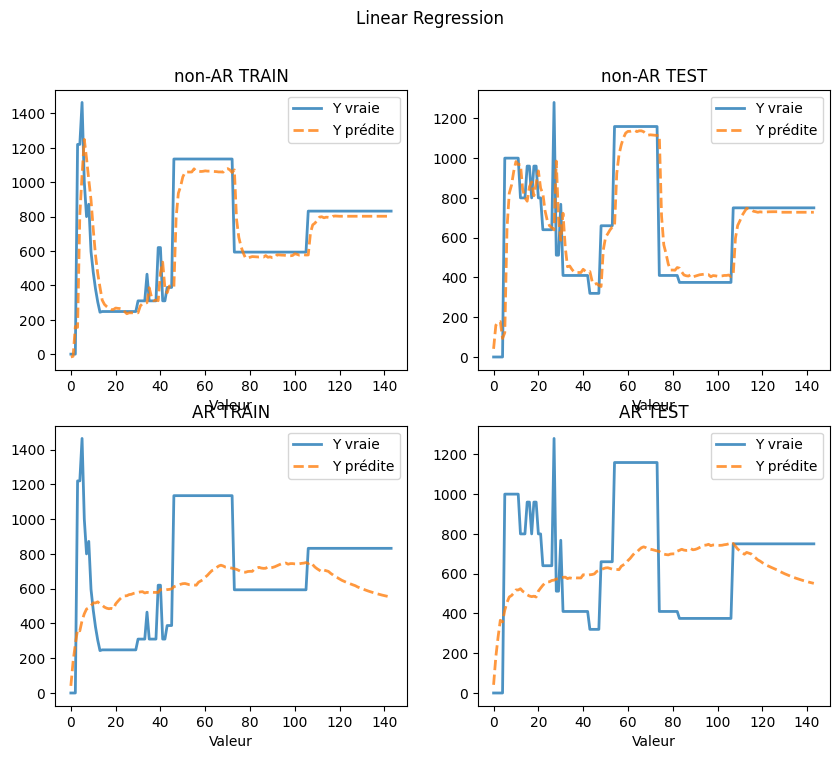

 20%|██        | 1/5 [00:01<00:04,  1.02s/it]

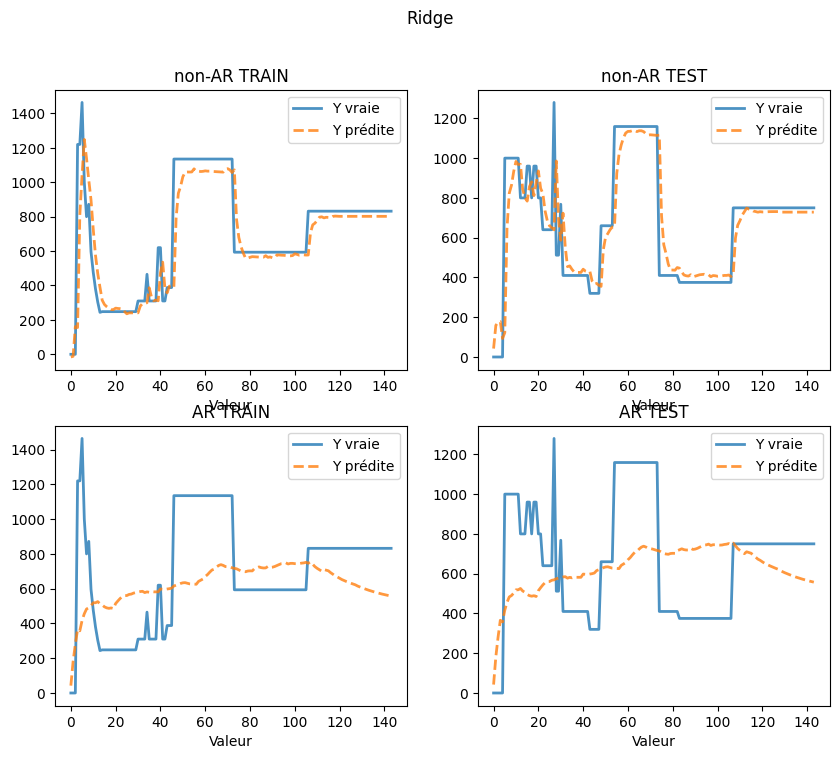

 40%|████      | 2/5 [00:02<00:03,  1.22s/it]

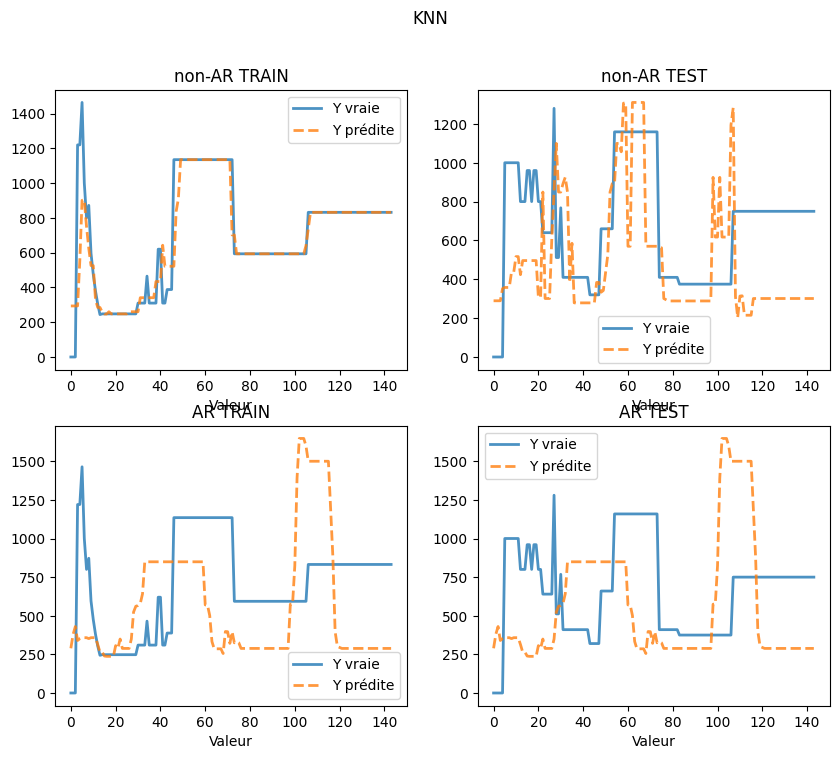

 60%|██████    | 3/5 [00:19<00:16,  8.31s/it]

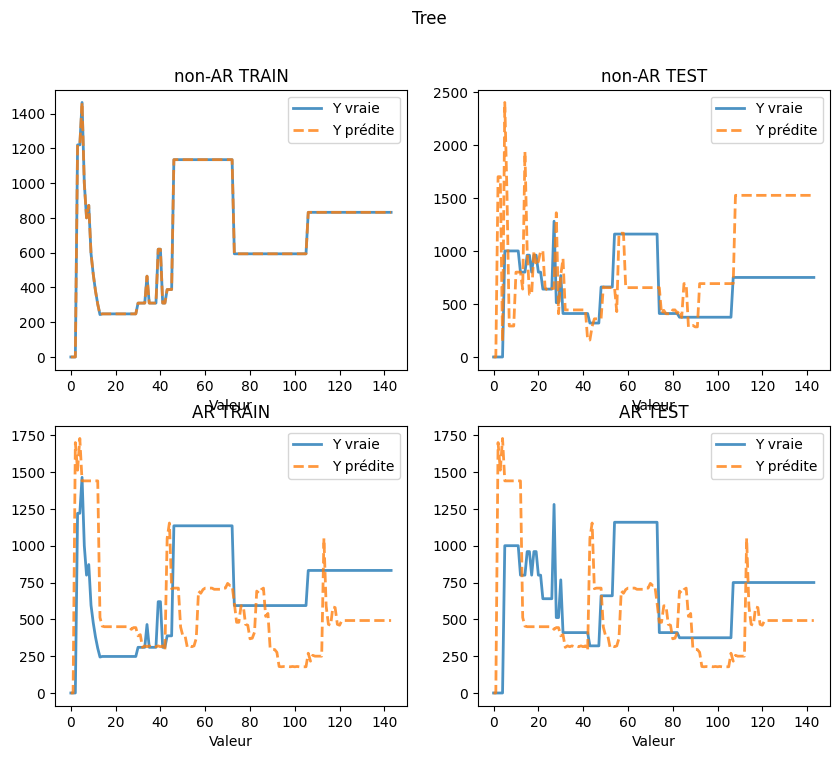

 80%|████████  | 4/5 [00:22<00:06,  6.32s/it]

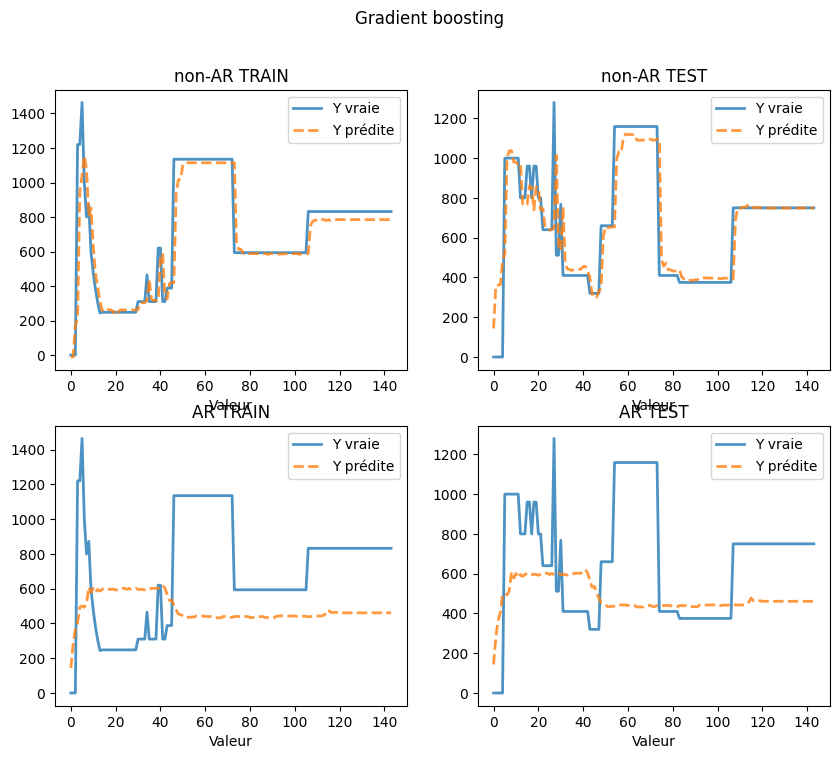

100%|██████████| 5/5 [00:42<00:00,  8.43s/it]


In [21]:
RESULTS = {
    model: {"TRAIN": {metric: 0 for metric in METRICS}, "TEST": {metric: 0 for metric in METRICS}} for model in MODELS
}

RESULTS_AR = {
    model: {"TRAIN": {metric: 0 for metric in METRICS}, "TEST": {metric: 0 for metric in METRICS}} for model in MODELS
}

for name, model in tqdm(MODELS.items()):

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    fig.suptitle(name)

    axes[0, 0].set_title("non-AR TRAIN")
    axes[0, 1].set_title("non-AR TEST")
    axes[1, 0].set_title("AR TRAIN")
    axes[1, 1].set_title("AR TEST")

    model.fit(X_train, Y_train)

    Y_pred_train: np.ndarray[float] = model.predict(X_train).reshape(T, -1)
    Y_pred_test: np.ndarray[float] = model.predict(X_test).reshape(T, -1)

    ml_utils.plot_pred_true(Y_train.reshape(T, N-S)[:, 10], Y_pred_train[:, 10], ax=axes[0, 0])
    ml_utils.plot_pred_true(Y_test[:, 10], Y_pred_test[:, 10], ax=axes[0, 1])

    Y_pred_train_ar: np.ndarray[float] = ml_utils.auto_regressive_pred(model, X_train[..., :-h], h)
    Y_pred_test_ar: np.ndarray[float] = ml_utils.auto_regressive_pred(model, X_test[..., :-h], h)

    ml_utils.plot_pred_true(Y_train.reshape(T, N-S)[:, 10], Y_pred_test_ar[:, 10], ax=axes[1, 0])
    ml_utils.plot_pred_true(Y_test[:, 10], Y_pred_test_ar[:, 10], ax=axes[1, 1])

    plt.show()
    plt.close()

    for metric in METRICS:

        RESULTS[name]["TRAIN"][metric], RESULTS[name]["TEST"][metric] = METRICS[metric](Y_train, Y_pred_train.reshape(-1)), METRICS[metric](Y_test.reshape(-1), Y_pred_test.reshape(-1))

        RESULTS_AR[name]["TRAIN"][metric], RESULTS_AR[name]["TEST"][metric] = METRICS[metric](Y_train, Y_pred_train_ar.reshape(-1)), METRICS[metric](Y_test.reshape(-1), Y_pred_test_ar.reshape(-1))


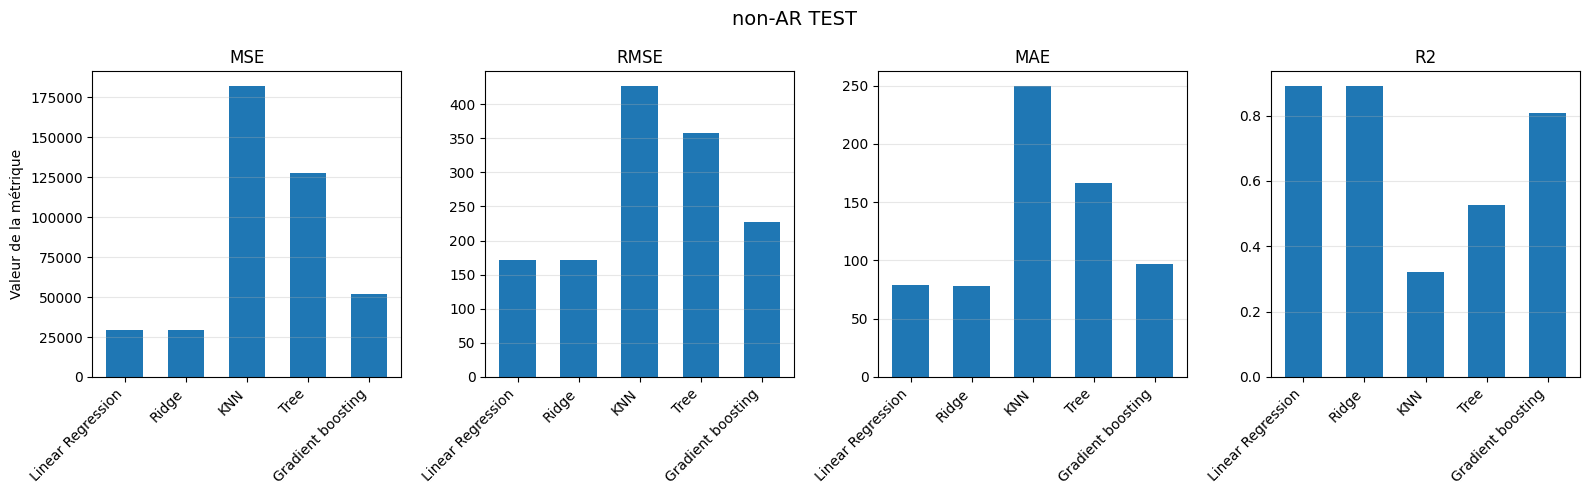

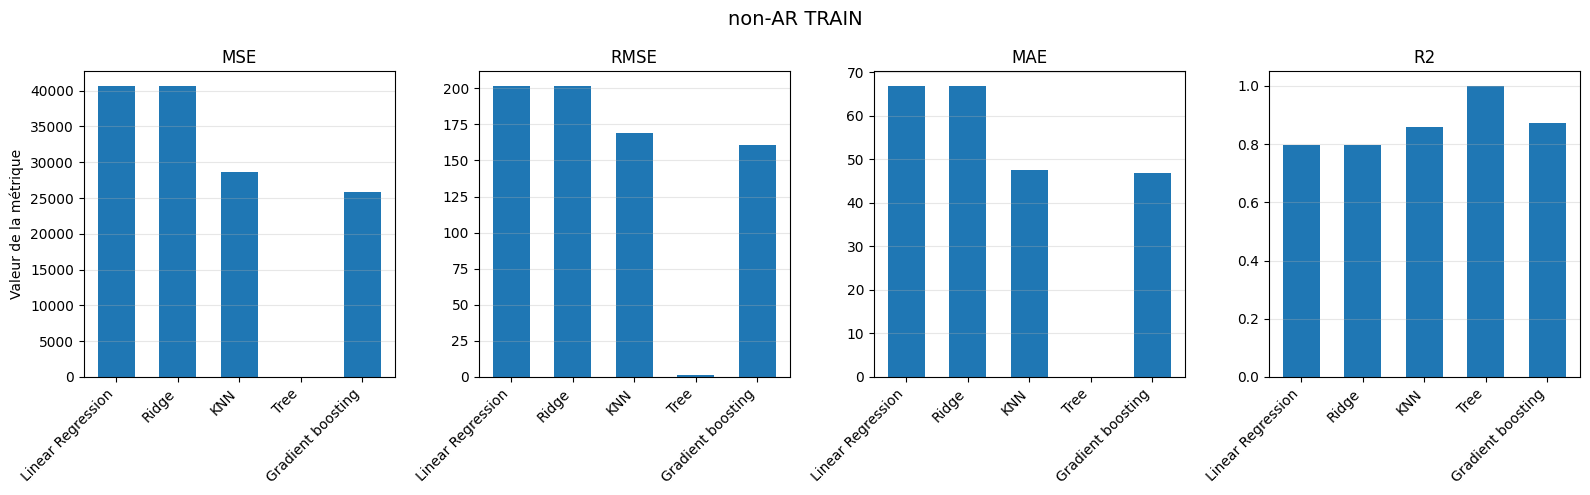

In [24]:
ml_utils.plot_metrics_bar(RESULTS, split="TEST", title="non-AR TEST")
ml_utils.plot_metrics_bar(RESULTS, split="TRAIN", title="non-AR TRAIN")

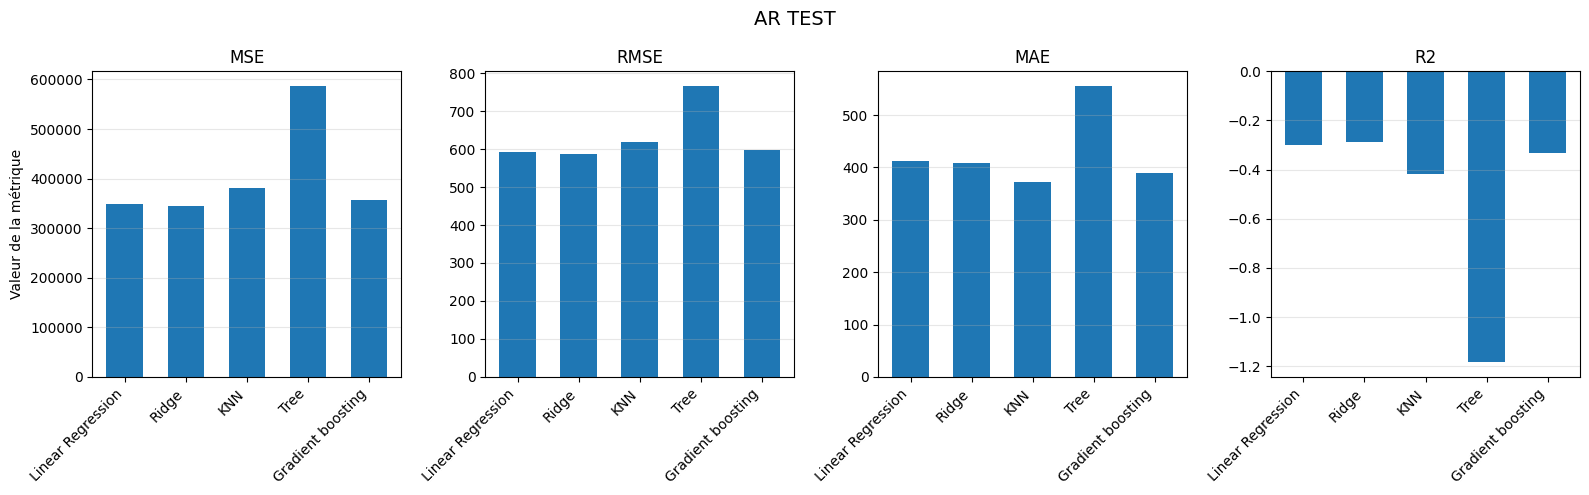

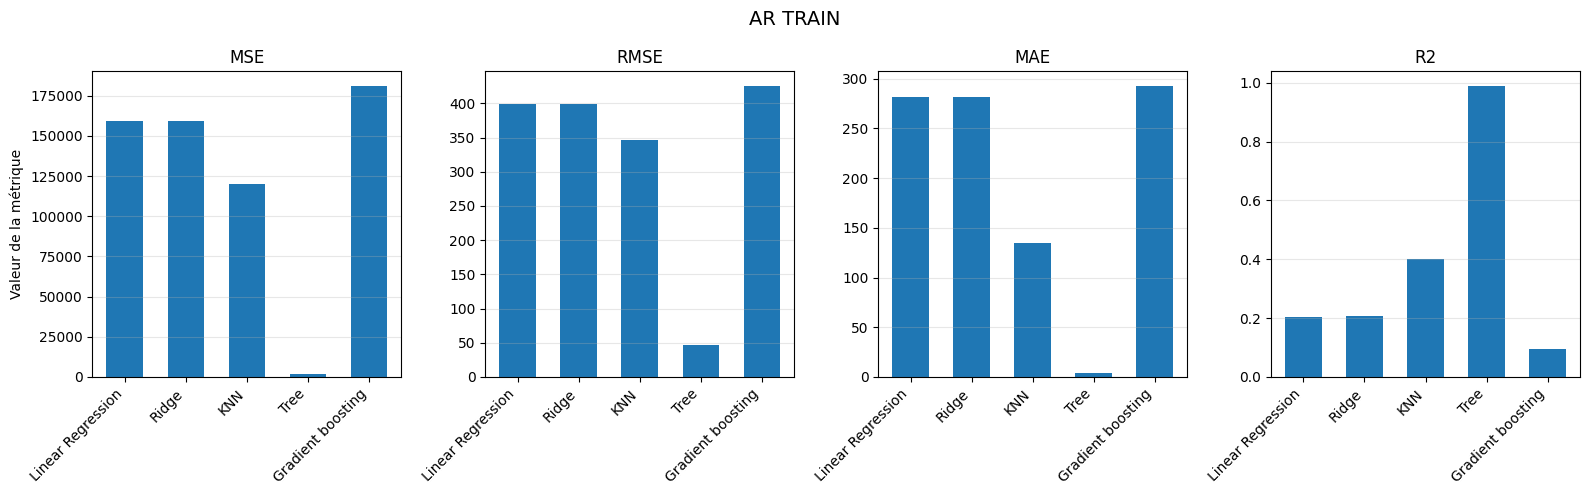

In [25]:
ml_utils.plot_metrics_bar(RESULTS_AR, split="TEST", title="AR TEST")
ml_utils.plot_metrics_bar(RESULTS_AR, split="TRAIN", title="AR TRAIN")